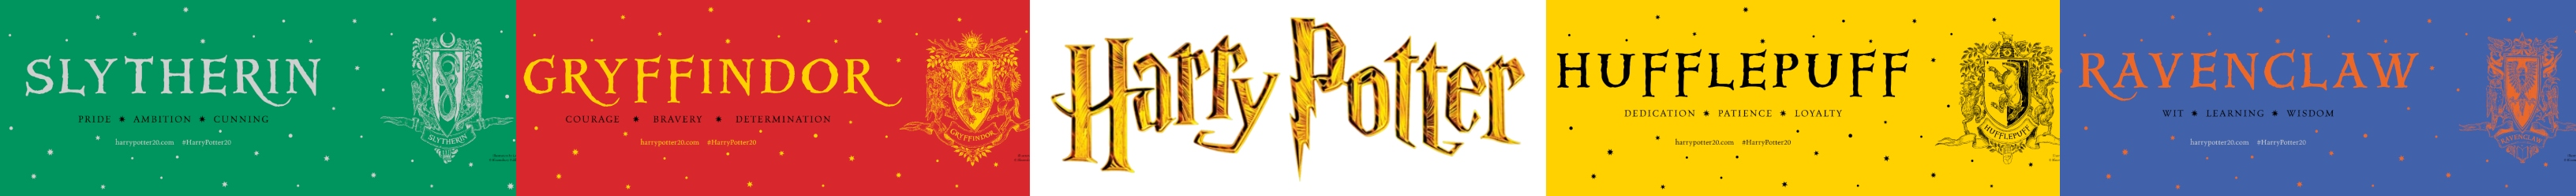

In [1]:
import pandas as pd
import numpy as np
import time
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import matplotlib.pyplot as plt
import os
import logging
import re 
import spacy
from spacy import displacy
import networkx as nx
from pyvis.network import Network

***

# Load links & get all character names

In [2]:
# Chrome options
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")

# Silent download of drivers
logging.getLogger('WDM').setLevel(logging.NOTSET)
os.environ['WDM_LOG'] = 'False'

# Create service
webdriver_service = Service(ChromeDriverManager().install())

# Create driver
driver = webdriver.Chrome(service = webdriver_service, options = chrome_options)

# Go to the categories page
page_url = 'https://harrypotter.fandom.com/wiki/Category:Individuals_by_eye_colour'
driver.get(page_url)

# Find categories
categories = driver.find_elements(by=By.CLASS_NAME, value='category-page__member-link')

# all 8 category links in one list
categories_list = []
for category in categories:
    category_url = category.get_attribute('href')
    category_name = category.text
    categories_list.append({'category_name': category_name, 'url': category_url})

In [3]:
categories_list

[{'category_name': 'Category:Black-eyed individuals',
  'url': 'https://harrypotter.fandom.com/wiki/Category:Black-eyed_individuals'},
 {'category_name': 'Category:Blue-eyed individuals',
  'url': 'https://harrypotter.fandom.com/wiki/Category:Blue-eyed_individuals'},
 {'category_name': 'Category:Brown-eyed individuals',
  'url': 'https://harrypotter.fandom.com/wiki/Category:Brown-eyed_individuals'},
 {'category_name': 'Category:Green-eyed individuals',
  'url': 'https://harrypotter.fandom.com/wiki/Category:Green-eyed_individuals'},
 {'category_name': 'Category:Grey-eyed individuals',
  'url': 'https://harrypotter.fandom.com/wiki/Category:Grey-eyed_individuals'},
 {'category_name': 'Category:Purple-eyed individuals',
  'url': 'https://harrypotter.fandom.com/wiki/Category:Purple-eyed_individuals'},
 {'category_name': 'Category:Red-eyed individuals',
  'url': 'https://harrypotter.fandom.com/wiki/Category:Red-eyed_individuals'},
 {'category_name': 'Category:Yellow-eyed individuals',
  'url

In [4]:
# Find characters in each category link
character_list = []

for category in categories_list:
    # go to categories page
    driver.get(category['url'])
    
    character_elems = driver.find_elements(by=By.CLASS_NAME, value = 'category-page__member-link')
    
    for elem in character_elems:
        character_list.append({'category': category['category_name'],'character': elem.text})
        
# Creating a dataframe for the characters      
characters = pd.DataFrame(character_list)

In [5]:
print('We have {x} characters.'.format(x = len(characters)))
characters

We have 580 characters.


,category,character
0,Category:Black-eyed individuals,Abraxan at the Magical Creatures Reserve
1,Category:Black-eyed individuals,Alastair
2,Category:Black-eyed individuals,Albus Dumbledore's great-great-grandfather's p...
3,Category:Black-eyed individuals,Nestor Amset
4,Category:Black-eyed individuals,Angry wizard
...,...,...
575,Category:Yellow-eyed individuals,Unidentified female Swedish Short-Snout
576,Category:Yellow-eyed individuals,Unidentified Hufflepuff student's snowy owl
577,Category:Yellow-eyed individuals,Unidentified Merman at the Great Lake
578,Category:Yellow-eyed individuals,Vaults Guardian


### desplaying number of characters in eace category 

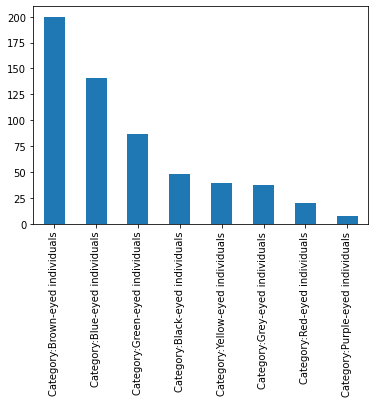

In [6]:
characters['category'].value_counts().plot(kind="bar");

### Cleaning

In [7]:
# Remove brackets and text within brackets

characters['character'] = characters['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x)) 
characters['character_firstname'] = characters['character'].apply(lambda x: x.split(' ', 1)[0])
characters['character'] = characters['character'].replace('Ronald Weasley', 'Ron')

In [8]:
characters[characters['character']=='Hermione Granger']

,category,character,character_firstname
278,Category:Brown-eyed individuals,Hermione Granger,Hermione


In [9]:
characters

,category,character,character_firstname
0,Category:Black-eyed individuals,Abraxan at the Magical Creatures Reserve,Abraxan
1,Category:Black-eyed individuals,Alastair,Alastair
2,Category:Black-eyed individuals,Albus Dumbledore's great-great-grandfather's p...,Albus
3,Category:Black-eyed individuals,Nestor Amset,Nestor
4,Category:Black-eyed individuals,Angry wizard,Angry
...,...,...,...
575,Category:Yellow-eyed individuals,Unidentified female Swedish Short-Snout,Unidentified
576,Category:Yellow-eyed individuals,Unidentified Hufflepuff student's snowy owl,Unidentified
577,Category:Yellow-eyed individuals,Unidentified Merman at the Great Lake,Unidentified
578,Category:Yellow-eyed individuals,Vaults Guardian,Vaults


In [10]:
# Load spacy English languague model
NER = spacy.load('en_core_web_sm')

Maximum number of characters that could be processed by NER() are 1000000
So we're going to slice and work on the first 1000000 characters only. (and maybe put the rest in a loop later)

In [12]:
# reading the books text file
books = open('Harry_Potter_all_books_preprocessed.txt','r').read()
book_doc = NER(books[:1000000])

In [13]:
len(books)

5992253

***

# Named entity list per sentence

In [14]:
sent_entity_df = []

# Loop through sentences, store named entity list for each sentence
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [15]:
sent_entity_df

,sentence,entities
0,"(THE, BOY, WHO, LIVED, Mr, and, Mrs, Dursley, ...","[Mrs Dursley, number four, Privet Drive]"
1,"(were, the, last, people)",[]
2,"(you, d, expect, to, be, involved, in, anythin...",[]
3,"(Dursley, was, the, director, of, a, firm, cal...","[Dursley, Grunnings]"
4,"(was, a, big, beefy, man, with, hardly, any, n...",[]
...,...,...
10517,"(Harry, felt, his, way, back, to, his, seat, ....",[Harry]
10518,"(Dunno, .There, was, a, squeaking, sound, and,...","[Dunno, Harry, Ron]"
10519,"(something, moving, out, there, Ron, said, .I,...","[Ron, Harrys]"
10520,"(dyou, know, what, s, going, on, ?)",[]


In [16]:
# Filtering out non-character entities
def filtering(entity_list, characters):
    return [entity for entity in entity_list 
            if entity in list(characters.character) 
            or entity in list(characters.character_firstname)]

In [17]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filtering(x, characters))

# Filter out sentences that don't have any character entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] for item in x])
sent_entity_df_filtered

C:\Users\user\AppData\Local\Temp/ipykernel_30616/977024664.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] for item in x])


,sentence,entities,character_entities
6,"(Dursley, s, had, a, small, son, called, Dudle...","[Dursley s, Dudley]",[Dudley]
13,"(boy, was, another, good, reason, for, keeping...",[Dudley],[Dudley]
15,"(Dursley, hummed, as, he, picked, out, his, mo...","[Dursley, Mrs Dursley, Dudley]",[Dudley]
17,"(half, past, eight, Mr, Dursley, picked, up, h...","[Dursley, Mrs Dursley, Dudley, Dudley]","[Dudley, Dudley]"
48,"(.He, was, sure, there, were, lots, of, people...","[Harry, Harry]","[Harry, Harry]"
...,...,...,...
10514,"(said, Rons, voice, from, behind, Harry, .Ouch...",[Harry],[Harry]
10517,"(Harry, felt, his, way, back, to, his, seat, ....",[Harry],[Harry]
10518,"(Dunno, .There, was, a, squeaking, sound, and,...","[Dunno, Harry, Ron]","[Harry, Ron]"
10519,"(something, moving, out, there, Ron, said, .I,...","[Ron, Harrys]",[Ron]


***

# Getting the relationships

In [18]:
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({'source': a, 'target': b})
            
relationship_df = pd.DataFrame(relationships)    
relationship_df

,source,target
0,Howard,Harry
1,Howard,Harry
2,Howard,Harry
3,Howard,Harry
4,Howard,Harry
...,...,...
8737,Harry,Ron
8738,Ron,Harry
8739,Harry,Ron
8740,Ron,Harry


In [19]:
# Sorting
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(['source','target'], sort = False, as_index = False).sum()
relationship_df

,source,target,value
0,Harry,Howard,5
1,Albus,James,4
2,Albus,Harry,58
3,Dudley,Harry,671
4,Dudley,Gordon,11
...,...,...,...
125,Albus,Arthur,5
126,Ron,Sirius,5
127,Arthur,Sirius,3
128,Hermione,Sirius,5


***

# The Visualization Part

In [20]:
graph = nx.from_pandas_edgelist(relationship_df, source = 'source', 
                            target = 'target', edge_attr = 'value', 
                            create_using = nx.Graph())

### Using Networkx

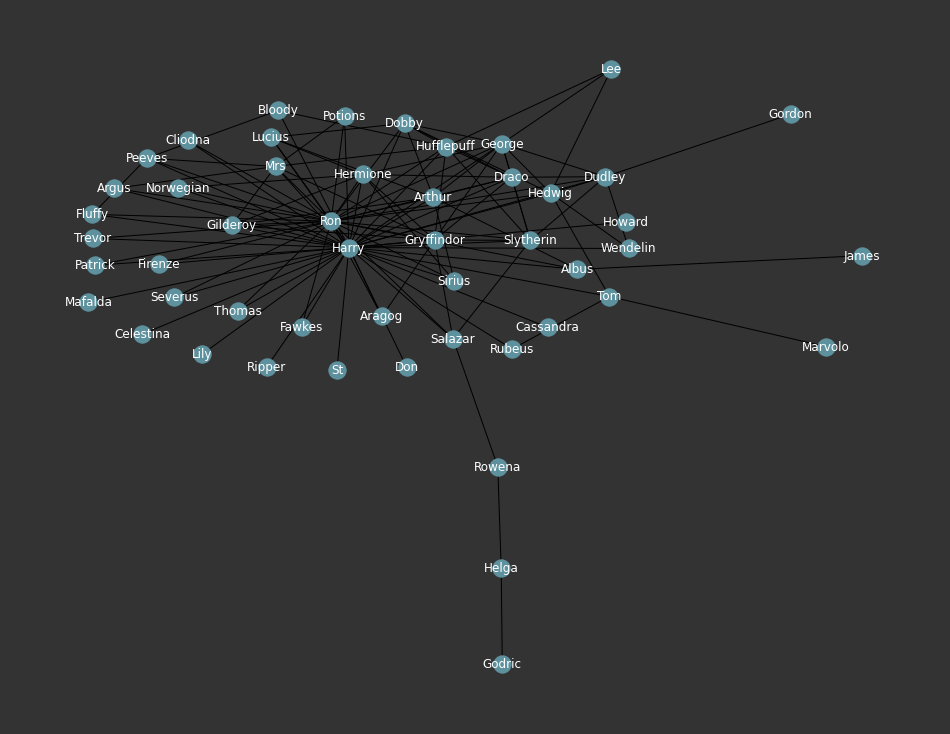

In [21]:
fig = plt.figure(figsize=(13,10))
p = nx.kamada_kawai_layout(graph)
nx.draw(graph, with_labels=True, node_color='#5e919e', font_color='white', 
        edge_color='#000000', edge_cmap=plt.cm.Blues, pos = p)
fig.set_facecolor("#333333")
plt.show()

### Using Pyvis

In [22]:
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(graph.degree)
nx.set_node_attributes(graph, node_degree, 'size')

net.from_nx(graph)
net.show("graph.html")

graph.html


In [23]:
# recreating the graph but coloring each group
group_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(graph.degree)
nx.set_node_attributes(graph, node_degree, 'group')

group_net.from_nx(graph)
group_net.show("group_graph.html")

group_graph.html


***

# The most mentioned characters in Harry Potter

In [24]:
degree_dict = nx.degree_centrality(graph)
sorted(degree_dict.items(), key=lambda p: p[1], reverse=True)

[('Harry', 0.8571428571428571),
 ('Ron', 0.6122448979591836),
 ('George', 0.22448979591836732),
 ('Gryffindor', 0.22448979591836732),
 ('Draco', 0.2040816326530612),
 ('Hufflepuff', 0.18367346938775508),
 ('Hermione', 0.18367346938775508),
 ('Arthur', 0.18367346938775508),
 ('Dudley', 0.16326530612244897),
 ('Slytherin', 0.16326530612244897),
 ('Hedwig', 0.16326530612244897),
 ('Mrs', 0.16326530612244897),
 ('Dobby', 0.16326530612244897),
 ('Gilderoy', 0.12244897959183673),
 ('Peeves', 0.1020408163265306),
 ('Lucius', 0.1020408163265306),
 ('Salazar', 0.1020408163265306),
 ('Albus', 0.08163265306122448),
 ('Tom', 0.08163265306122448),
 ('Sirius', 0.08163265306122448),
 ('Potions', 0.061224489795918366),
 ('Lee', 0.061224489795918366),
 ('Bloody', 0.061224489795918366),
 ('Argus', 0.061224489795918366),
 ('Fluffy', 0.061224489795918366),
 ('Norwegian', 0.061224489795918366),
 ('Aragog', 0.061224489795918366),
 ('Wendelin', 0.061224489795918366),
 ('Cliodna', 0.04081632653061224),
 ('Fir

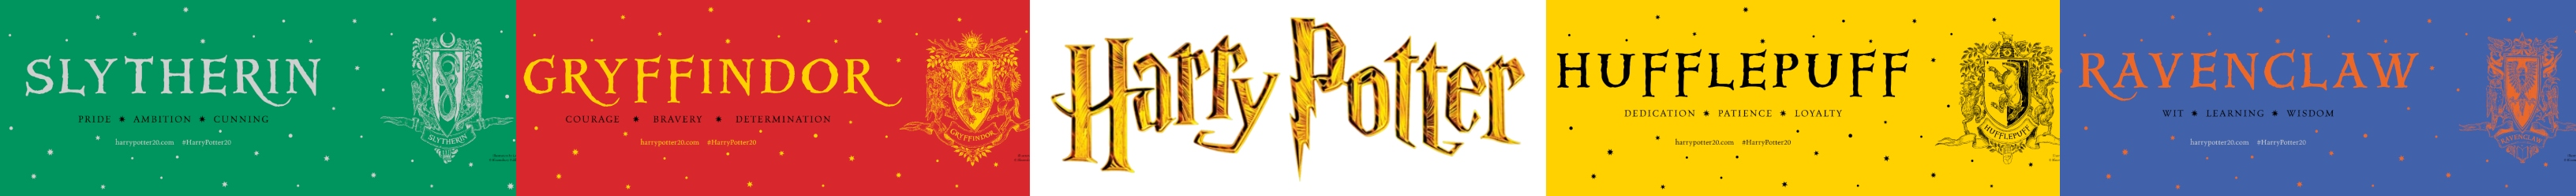